# Data Scraping

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Fetch data types
url = 'http://www.data.jma.go.jp/obd/stats/data/en/smp/index.html'
soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
select = soup.findAll('select', {'id': 'view'})[0]
data_types = dict(enumerate(select.stripped_strings, start=1))

# Fetch data
data = {}
station_ID = '47662'
url_p1 = 'http://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.' + \
    'php?block_no='
url_p2 = '&view='

for key in data_types:
    url = url_p1 + station_ID + url_p2 + str(key)

    soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
    table = soup.find('table', {'class': 'data2_s'})
    col_names = [x.string for x in table.find_all('th')]

    temp_data = pd.DataFrame()

    html_data = table.find_all('td')
    row = -1
    col = 0
    prev_class = None
    for item in html_data:
        if item.attrs == {'style': 'text-align:center'}:
            col = 0
            row += 1
            temp_data.loc[row, col] = item.string
        else:
            col += 1
            if (item.attrs != {'class': ['data_0_0_0_0']} and
               prev_class == {'class': ['data_0_0_0_0']}):
                temp_data.loc[row, col] = item.string + ' h_change'
            else:
                temp_data.loc[row, col] = item.string
            prev_class = item.attrs

    temp_data.columns = col_names
    temp_data = temp_data.drop('Annual', axis=1).set_index('Year')

    data.update({data_types[key]: temp_data})

data = pd.Panel(data)


# Exploratory Data Analysis

### Descriptive Statistics

In [2]:
df = data.to_frame(filter_observations=False).apply(pd.to_numeric,
                                                    errors='coerce')

# Clean column names
bannedWord = ['Monthly', 'mean', 'daily', 'total', 'of', 'percentage']
df.columns = [' '.join(word for word in string.split()
                       if word not in bannedWord) for string in df.columns]

df.describe().apply(round).to_csv('describe.csv')
df.describe().apply(round)


,air temperature,cloud amount,maximum temperature,minimum temperature,global solar radiation,possible sunshine,relative humidity,sea level air pressure,station level pressure,vapor pressure,wind speed,precipitation,snowfall depth,sunshine duration
count,1699.0,1044.0,1701.0,1701.0,636.0,1522.0,1701.0,1704.0,804.0,1041.0,779.0,1690.0,198.0,1522.0
mean,15.0,6.0,19.0,11.0,12.0,46.0,69.0,1014.0,1010.0,13.0,3.0,129.0,4.0,168.0
std,8.0,2.0,7.0,8.0,3.0,12.0,10.0,3.0,4.0,8.0,0.0,91.0,9.0,39.0
min,1.0,2.0,6.0,-4.0,6.0,11.0,36.0,1004.0,1002.0,3.0,2.0,0.0,0.0,39.0
25%,8.0,5.0,12.0,3.0,9.0,38.0,62.0,1011.0,1008.0,6.0,3.0,64.0,0.0,141.0
50%,15.0,7.0,20.0,11.0,12.0,46.0,71.0,1014.0,1010.0,12.0,3.0,112.0,0.0,168.0
75%,22.0,8.0,26.0,19.0,14.0,55.0,78.0,1017.0,1013.0,20.0,4.0,171.0,3.0,195.0
max,30.0,10.0,34.0,27.0,21.0,79.0,88.0,1023.0,1021.0,29.0,5.0,780.0,57.0,304.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1728 entries, (1875, Jan) to (2018, Dec)
Data columns (total 14 columns):
air temperature           1699 non-null float64
cloud amount              1044 non-null float64
maximum temperature       1701 non-null float64
minimum temperature       1701 non-null float64
global solar radiation    636 non-null float64
possible sunshine         1522 non-null float64
relative humidity         1701 non-null float64
sea level air pressure    1704 non-null float64
station level pressure    804 non-null float64
vapor pressure            1041 non-null float64
wind speed                779 non-null float64
precipitation             1690 non-null float64
snowfall depth            198 non-null float64
sunshine duration         1522 non-null float64
dtypes: float64(14)
memory usage: 195.4+ KB


### Correlation Heatmap

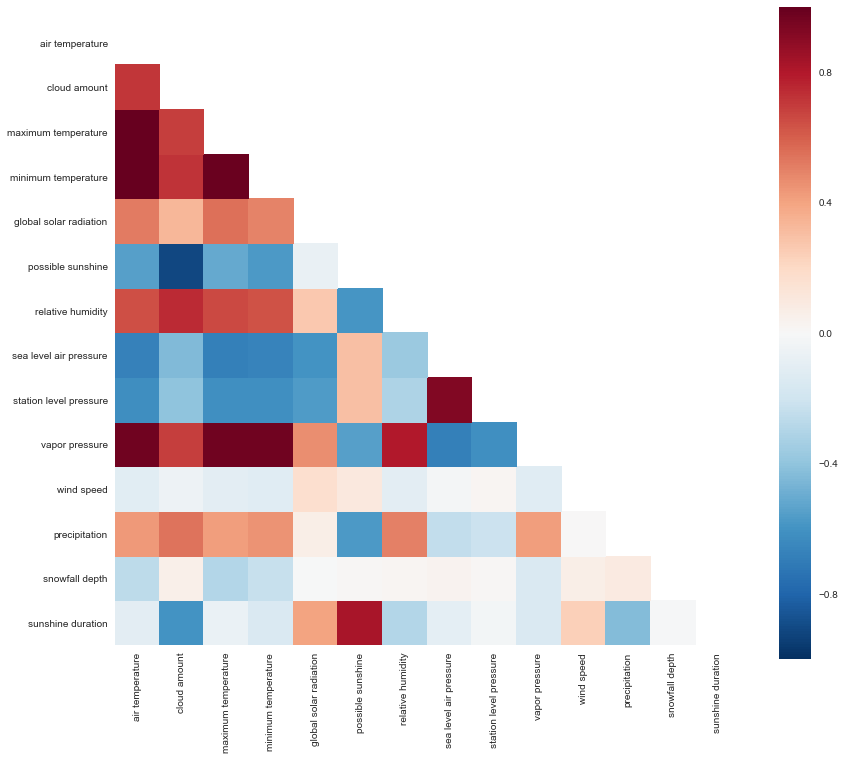

In [4]:
import seaborn as sns

%matplotlib inline

sns.set(style='white', rc={'figure.figsize': (14, 12)})

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, vmin=-1, vmax=1, square=True, mask=mask)

# ax.get_figure().savefig('corr_heatmap.png', dpi=400)


### Stacked KDE Plot

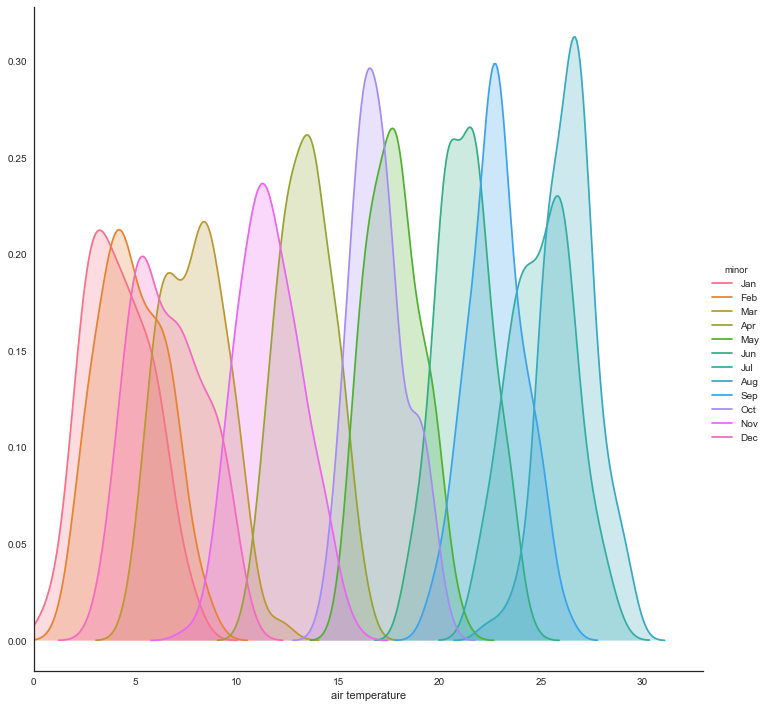

In [5]:
kde_plot = (sns.FacetGrid(df.reset_index(),
            hue='minor',
            size=10,
            xlim=(0, 33))
            .map(sns.kdeplot, 'air temperature', shade=True)
            .add_legend())
# kde_plot.savefig('kde_plot.png', dpi=400)


### Time Series Plot

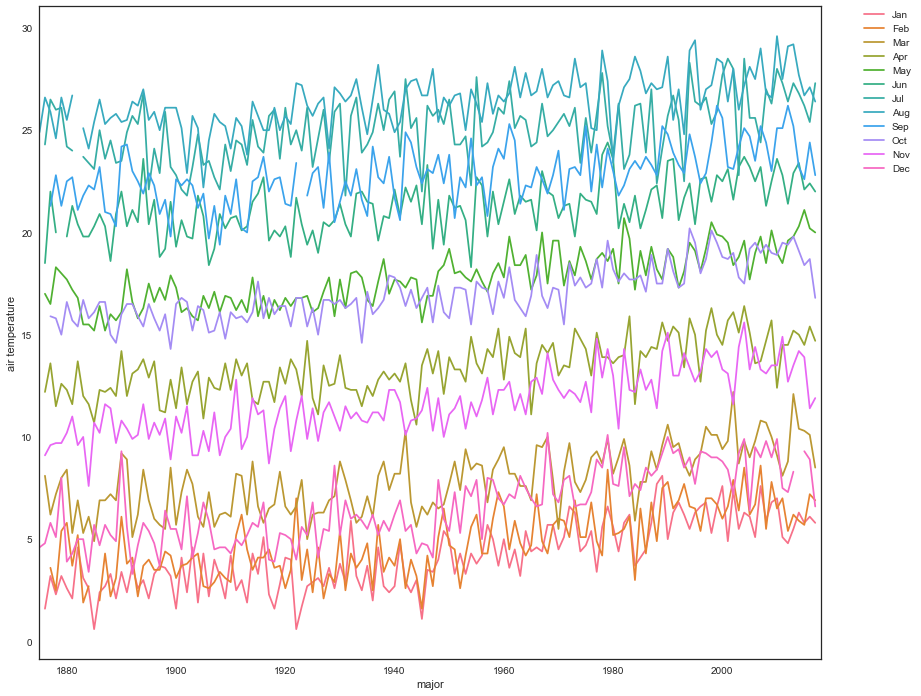

In [6]:
ts_df = df.reset_index()
ts = sns.tsplot(data=ts_df,
                time='major',
                unit='minor',
                value='air temperature',
                condition='minor')
ts.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ts.get_figure().savefig('ts_plot.png', dpi=400)


# Preprocessing

In [7]:
# Convert panel to dataframe
model_df = data.to_frame(filter_observations=False)
variables = ['air temperature', 'cloud amount', 'global solar radiation',
             'relative humidity', 'station level pressure', 'precipitation',
             'snowfall depth']

# Rename columns
model_df.columns = [' '.join(word for word in string.split() if word not
                             in bannedWord) for string in model_df.columns]

# Select only variable of interest and add month data
model_df = model_df[variables].reset_index(level='minor').dropna()

# Create 'homogeneity' dummy variable
model_df['homogeneity'] = \
    np.cumsum(model_df.sum(axis=1).str.contains('h_change')).astype('str')

# Replace '--' with 0 in 'snowfall depth' data
model_df['snowfall depth'].replace('--', 0, inplace=True)

dummy_var = ['minor', 'homogeneity']
numerical_var = model_df.columns.drop(dummy_var)

# Keep only 'Reliable' data points and drop NaN
model_df[numerical_var] = model_df[numerical_var].apply(pd.to_numeric,
                                                        errors='coerce')

# Create dummy variables
model_df = pd.get_dummies(model_df).dropna()

# Add constant term
model_df['constant'] = 1

# Reorder columns of the dataframe
cols = ['air temperature', 'constant', 'cloud amount',
        'global solar radiation', 'relative humidity',
        'station level pressure', 'precipitation', 'snowfall depth',
        'minor_Jan', 'minor_Feb', 'minor_Mar', 'minor_Apr', 'minor_May',
        'minor_Jun', 'minor_Jul', 'minor_Aug', 'minor_Sep', 'minor_Oct',
        'minor_Nov', 'minor_Dec', 'homogeneity_0', 'homogeneity_1',
        'homogeneity_2', 'homogeneity_3']

model_df = model_df[cols]


In [8]:
model_df.head(10)

,air temperature,constant,cloud amount,global solar radiation,relative humidity,station level pressure,precipitation,snowfall depth,minor_Jan,minor_Feb,...,minor_Jul,minor_Aug,minor_Sep,minor_Oct,minor_Nov,minor_Dec,homogeneity_0,homogeneity_1,homogeneity_2,homogeneity_3
major,,,,,,,,,,,,,,,,,,,,,
1961,3.6,1,3.6,9.2,54.0,1015.2,39.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1961,4.5,1,3.7,12.1,49.0,1011.8,43.5,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
1961,8.2,1,6.3,13.9,61.0,1016.9,106.6,4.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1961,14.9,1,6.3,16.4,63.0,1013.9,183.1,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1961,19.8,1,7.5,15.9,69.0,1011.2,55.5,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1961,22.6,1,7.9,14.7,75.0,1009.0,305.5,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1961,27.4,1,7.4,16.7,74.0,1007.9,29.5,0.0,0,0,...,1,0,0,0,0,0,1,0,0,0
1961,26.8,1,7.1,13.4,77.0,1009.2,30.9,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0
1961,25.3,1,5.9,12.7,72.0,1013.0,37.0,0.0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [9]:
model_df.shape

(619, 24)

In [10]:
model_df.to_csv('data.csv', index=False)